In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
%reload_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Chargement des données
final_dataset = pd.read_csv("datasets/clustering_dataset.csv",
                            index_col='customer_unique_id')

# Conversion au format datetime
final_dataset['order_purchase_timestamp'] = pd.to_datetime(
    final_dataset.order_purchase_timestamp)

# Renommage de variable
final_dataset.rename(columns={'order_purchase_timestamp':
                              'order_date'}, inplace=True)

# Sélection des variables numériques
num_dataset = final_dataset.select_dtypes(exclude=['object'])
num_dataset = num_dataset.drop(['customer_zip_code_prefix'], axis=1)

In [3]:
df = num_dataset.copy()
df = df.reset_index()
df.head(3)

,customer_unique_id,mean_desc_name_len,monetary_value,mean_review_score,mean_photos_qty,order_date,nb_items,nb_unique_items,price,freight_value,mean_prod_name_len,review_nb,comment_msg_nb,payment_type_nb,payment_instlmt_nb,latitude,longitude,frequency,recency,day,month,hour
0,0000366f3b9a7992bf8c76cfdf3221e2,236.0,141.90,5.0,1.0,2018-05-10 10:56:27,1.0,1.0,129.9,12.00,60.0,1.0,1.0,1.0,8.0,-23.337679,-46.826739,1,112,10,5,10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,635.0,27.19,4.0,1.0,2018-05-07 11:11:27,1.0,1.0,18.9,8.29,56.0,1.0,0.0,1.0,1.0,-23.557876,-46.788754,1,115,7,5,11
2,0000f46a3911fa3c0805444483337064,177.0,86.22,3.0,3.0,2017-03-10 21:05:03,1.0,1.0,69.0,17.22,49.0,1.0,0.0,1.0,8.0,-27.543787,-48.631973,1,537,10,3,21


In [4]:
print(df.order_date.min())
print(df.order_date.max())

2016-10-03 16:56:50
2018-08-29 15:00:37


In [5]:
df[df['order_date'] < "2018-01-01"]['order_date'].sort_values()

16974   2016-10-03 16:56:50
35014   2016-10-03 21:13:36
50265   2016-10-03 22:06:03
48320   2016-10-03 22:31:31
41290   2016-10-03 22:44:10
                ...        
82246   2017-12-31 21:10:02
62079   2017-12-31 21:17:54
65895   2017-12-31 22:14:53
33303   2017-12-31 23:24:10
9221    2017-12-31 23:29:31
Name: order_date, Length: 40989, dtype: datetime64[ns]

In [6]:
df[(df['order_date'] > "2018-01-01") &
   (df['order_date'] <= "2018-01-02")]['order_date'].sort_values()

5790    2018-01-01 02:48:41
52811   2018-01-01 08:37:46
4043    2018-01-01 08:45:04
405     2018-01-01 09:36:21
50571   2018-01-01 10:24:03
                ...        
70156   2018-01-01 23:15:14
72953   2018-01-01 23:20:33
1591    2018-01-01 23:22:57
84545   2018-01-01 23:45:49
67903   2018-01-01 23:50:59
Name: order_date, Length: 68, dtype: datetime64[ns]

On supposera ici, compte tenu du travail réalisé dans le notebook `POLIST_02_notebookessais.ipynb`, que le nombre de cluster à considérer est `k=6`. 

# Objectif

L'objectif de la cellule suivante va être __d'évaluer la stabilité de nos clusters__.

Pour cela, nous allons comparer, à l'aide de l'__ARI__, les clusters affectés aux clients ayant commandé en 2016 et 2017 (`true labels`) à leurs nouveaux clusters lorsqu'on rajoute de nouveaux clients ayant commandé en 2018 (`new_labels`).

Tant que l'ARI reste comprise entre 0.6 et 1, alors on peut considérer que la prise en compte de nouveaux clients n'influence pas la structure sous-jacente des clusters.

Si l'ARI devient inférieur à 0.6, alors les clusters deviennent obsolètes ; il devient nécessaire de mettre à jour nos clusters. 

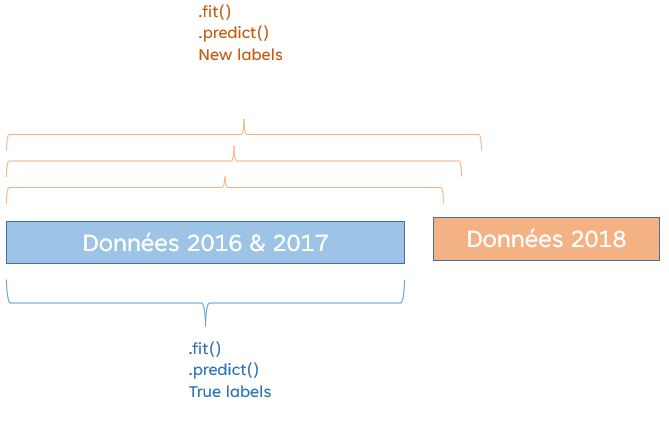

In [7]:
Image(filename='images/stabilite.JPG', width=600)

In [8]:
list_of_ari = []
nb_customers_after_thres = []
colonnes_suppression = ['customer_unique_id', 'order_date']
scaler = PowerTransformer()
thresholds = pd.date_range(start="2018-01-02",
                           end="2018-01-31",
                           freq='D').strftime('%Y-%m-%d').tolist()
days = pd.date_range(start="2018-01-01",
                     end="2018-01-16",
                     freq='D').strftime('%Y-%m-%d').tolist()

print("-------------START-------------")
for i in range(len(thresholds)):

    print(f"Threshold : {days[i]}")

    # Clients qui ont commandé jusqu'au 31 décembre 2017 inclus
    p0 = df[df['order_date'] < "2018-01-01"]

    # Clients qui on commandé du 1er janvier à la date threshold
    p1 = df[(df['order_date'] > "2018-01-01") &
            (df['order_date'] <= thresholds[i])]

    print("Number of customer before threshold = {}".format(len(p0)))
    print("Number of customer after threshold = {}".format(len(p1)))

    nb_customers_after_thres.append(len(p1))

    # Concaténation des clients p0 et p1
    p0_p1 = pd.concat([p0, p1])

    # Suppression des colonnes non utilisées par l'algorithme
    p0 = p0.drop(colonnes_suppression, axis=1)
    p0_p1 = p0_p1.drop(colonnes_suppression, axis=1)

    # Fit sur les données avant threshold
    scaler.fit(p0)

    # Transformation des données avant threshold
    p0 = pd.DataFrame(scaler.transform(p0), columns=p0.columns)

    # Transformation de l'ensemble des données (avant et après threshold
    p0_p1 = pd.DataFrame(scaler.transform(p0_p1), columns=p0_p1.columns)

    # Instantiation des k-means
    kmeans = KMeans(n_clusters=6, random_state=1)

    # Fit sur les données avant threshold
    kmeans.fit(p0)

    # Predict sur les données avant threshold
    true_labels = kmeans.predict(p0)

    # Fit sur l'ensemble des données
    kmeans.fit(p0_p1)

    # Precit sur l'ensemble des données
    new_labels = kmeans.predict(p0_p1)
    new_labels = new_labels[:len(true_labels)]

    # Calcul de l'ARI
    ari = round(adjusted_rand_score(true_labels, new_labels), 4)

    # Affichage de l'ARI
    print(f"ARI = {ari}")
    list_of_ari.append(ari)

    # Arrêt de la boucle si l'ARI devient trop faible
    if ari < 0.6:
        print("-------------END-------------")
        break

    print("-"*45)

-------------START-------------
Threshold : 2018-01-01
Number of customer before threshold = 40989
Number of customer after threshold = 68
ARI = 0.9992
---------------------------------------------
Threshold : 2018-01-02
Number of customer before threshold = 40989
Number of customer after threshold = 252
ARI = 0.987
---------------------------------------------
Threshold : 2018-01-03
Number of customer before threshold = 40989
Number of customer after threshold = 452
ARI = 0.9871
---------------------------------------------
Threshold : 2018-01-04
Number of customer before threshold = 40989
Number of customer after threshold = 680
ARI = 0.987
---------------------------------------------
Threshold : 2018-01-05
Number of customer before threshold = 40989
Number of customer after threshold = 866
ARI = 0.9847
---------------------------------------------
Threshold : 2018-01-06
Number of customer before threshold = 40989
Number of customer after threshold = 1067
ARI = 0.9933
--------------

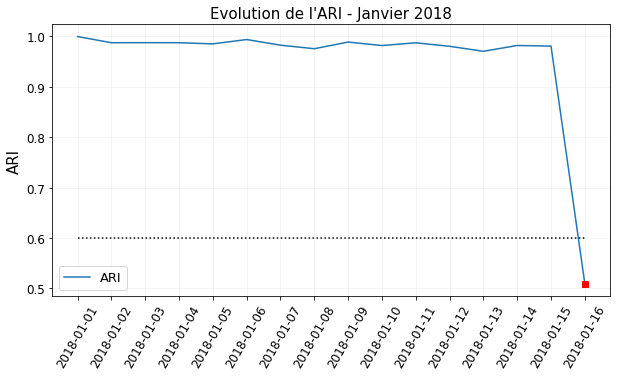

In [9]:
idx = np.argmin(list_of_ari)
plt.figure(figsize=(10, 5))
plt.plot(days[:len(list_of_ari)], list_of_ari, label="ARI")
plt.plot([days[0], days[idx]], [0.6, 0.6], "k:")
plt.xticks(rotation=60)
plt.ylabel("ARI", fontsize=15)
plt.legend(fontsize=13)
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='0.95')
plt.plot(days[idx], list_of_ari[idx], "rs")
plt.title("Evolution de l'ARI - Janvier 2018", fontsize=15)
plt.show()

In [10]:
print(nb_customers_after_thres[:idx])
print(np.mean(list_of_ari[:idx]))

[68, 252, 452, 680, 866, 1067, 1253, 1522, 1753, 2017, 2262, 2484, 2686, 2898, 3181]
0.9842466666666669


# Synthèse

- Stabilité des clusters : 
    - ARI stable et élevée (moyenne à 0.98) après avoir considéré 3181 nouveaux clients
    - dégradation drastique de l'ARI au bout du seizième jours
- Proposition de contrat de maintenance :
    - Nouveau clustering toutes les 2 semaines